In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import tensorflow as tf

%load_ext autoreload
%autoreload 2
from base import datahandler, prediction_models, evaluation, utils


2024-01-20 21:06:50.379980: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-20 21:06:50.380102: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-20 21:06:50.393134: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-20 21:06:50.440790: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-20 21:06:51.612922: W tensorflow/compiler/tf2

In [2]:
# model_ew = tf.keras.models.load_model('/home/david/Code/splid-challenge/wandb/run-20240112_140537-85ahbucq/files\model_85ahbucq.hdf5')
# model_ew.save('models/ew_localizer.hdf5')


In [3]:
# Define the directory paths
challenge_data_dir = Path('dataset/phase_1/')
data_dir = challenge_data_dir / "train"
labels_dir = challenge_data_dir / 'train_labels.csv'

split_dataframes = datahandler.load_and_prepare_dataframes(data_dir, labels_dir)

some_dataframes = {df_k : split_dataframes[df_k] for df_k in list(split_dataframes.keys())[:40]}

In [28]:
input_features = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)',
       'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Latitude (deg)',
       'Longitude (deg)', 'Altitude (m)', 'X (m)', 'Y (m)', 'Z (m)',
       'Vx (m/s)', 'Vy (m/s)', 'Vz (m/s)']

input_features_reduced = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)',
       'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Latitude (deg)',
       'Longitude (deg)', 'Altitude (m)']

ew_input_features = ['Eccentricity', 'Semimajor Axis (m)', 'Argument of Periapsis (deg)', 'Longitude (deg)', 'Altitude (m)']
ew_input_features = ['Eccentricity', 'Longitude (deg)', 'Latitude (deg)']

ns_input_features = ['Eccentricity', 'Semimajor Axis (m)', 'RAAN (deg)', 'Inclination (deg)', 'Latitude (deg)', 'Altitude (m)']


utils.set_random_seed(42)
ds_gen_ew = datahandler.DatasetGenerator(split_df=split_dataframes, input_features=ew_input_features,
                                      with_labels=True, pad_location_labels=0,
                                      nonbinary_padding=[100.0, 80.0, 60.0, 40.0, 20.0],
                                      train_val_split=0.8, input_stride=1, padding='none',
                                      transform_features=True,
                                      input_history_steps=24, input_future_steps=24, seed=69)

# ds_gen_ns = datahandler.DatasetGenerator(split_df=split_dataframes, input_features=ns_input_features,
#                                       with_labels=True, pad_location_labels=2,
#                                       train_val_split=0.8, input_stride=4, padding='none',
#                                       transform_features=True,
#                                       input_history_steps=80, input_future_steps=80, seed=69)

=========================Creating Generator=======================
Seed: 69
nTrain: 200 nVal: 50 (0.80)
Padding: none
Scaling: True 
Horizons: 24-24 @ stride 1
Sin-Transformed features: []
Padding node locations in non-binary fashion ([20.0, 40.0, 60.0, 80.0, 100.0, 80.0, 60.0, 40.0, 20.0])
=========================Finished Generator=======================


In [ ]:
train_ew, val_ew = ds_gen_ew.get_datasets(512, label_features=['EW_Node_Location'], shuffle=True, stride=4)

print(train_ew.element_spec)

#dense_model = prediction_models.Dense_NN(train_combined, conv1d_layers=[[64,32],[32,16]], dense_layers=[64,32], l2_reg=0.0001, mixed_dropout=0.1, lr_scheduler=[30000,0.8], seed=0)
model_ew = prediction_models.Dense_NN(val_ew, conv1d_layers=[], dense_layers=[256,128,64,32], l2_reg=0.0, mixed_dropout=0.0, lr_scheduler=[], seed=0)
#dense_model = prediction_models.CNN(train_combined, conv_layers=[[64,6],[64,3],[64,3]], l2_reg=0.001, mixed_dropout=0.15, lr_scheduler=[20000,0.8], seed=0)
#model_ew = prediction_models.LSTM_NN(val_ew, input_dropout=0.0, mixed_dropout=0.1, lstm_layers=[128,64], dense_layers=[32,16], l2_reg=0.0001, lr_scheduler=[], seed=1)

train_ew = train_ew.map(lambda x,y:(x,y['EW_Node_Location']))
val_ew = val_ew.map(lambda x,y:(x,y['EW_Node_Location'])) # temporary fix to allow class weights

model_ew.summary()
hist = model_ew.fit(train_ew, val_ds=val_ew, epochs=20, verbose=1, plot_hist=True, 
                    class_weight={0: 1.0, 1: 2.0}, 
                    callbacks=[])
#model_ew.model.save('models/ew_localizer.hdf5')

(TensorSpec(shape=(None, 48, 3), dtype=tf.float64, name=None), {'EW_Node_Location_nb': TensorSpec(shape=(None,), dtype=tf.float32, name=None)})
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 48, 3)]           0         
                                                                 
 flatten_1 (Flatten)         (None, 144)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                9280      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 EW_Node_Location_nb (Dense  (None, 1)                 33        
 )                                                               
                                               

/home/david/Code/splid-challenge/base/prediction_models.py:84: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


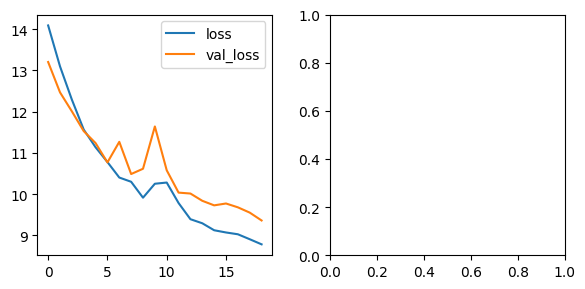

In [29]:
train_ew, val_ew = ds_gen_ew.get_datasets(512, label_features=['EW_Node_Location_nb'], shuffle=True, stride=4)

print(train_ew.element_spec)

model_ew = prediction_models.Dense_NN_regression(val_ew, conv1d_layers=[], dense_layers=[64,32],
                                                 l2_reg=0.0, mixed_dropout=0.0,
                                                 lr_scheduler=[0.001,20000,0.9],
                                                 final_activation='relu',
                                                 seed=0)

model_ew.summary()
hist = model_ew.fit(train_ew, val_ds=val_ew, epochs=20, verbose=1, plot_hist=True, callbacks=[])


Starting training. Optimizing "val_accuracy"
Epoch 1/10
209/209 [==============================] - 2s 9ms/step - loss: 8.6642 - mse: 8.6642 - mae: 0.1808 - val_loss: 9.2637 - val_mse: 9.2637 - val_mae: 0.1807
Epoch 2/10
209/209 [==============================] - 2s 7ms/step - loss: 8.5869 - mse: 8.5869 - mae: 0.1803 - val_loss: 9.5053 - val_mse: 9.5053 - val_mae: 0.1788
Epoch 3/10
209/209 [==============================] - 2s 7ms/step - loss: 8.6184 - mse: 8.6184 - mae: 0.1880 - val_loss: 11.7427 - val_mse: 11.7427 - val_mae: 0.2403
Epoch 4/10
209/209 [==============================] - 2s 8ms/step - loss: 9.6154 - mse: 9.6154 - mae: 0.1821 - val_loss: 9.6392 - val_mse: 9.6392 - val_mae: 0.2510
Epoch 5/10
209/209 [==============================] - 2s 8ms/step - loss: 8.9486 - mse: 8.9486 - mae: 0.2009 - val_loss: 11.8065 - val_mse: 11.8065 - val_mae: 0.2000
Epoch 6/10
209/209 [==============================] - 2s 8ms/step - loss: 10.0458 - mse: 10.0458 - mae: 0.1806 - val_loss: 11.2171 

/home/david/Code/splid-challenge/base/prediction_models.py:84: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


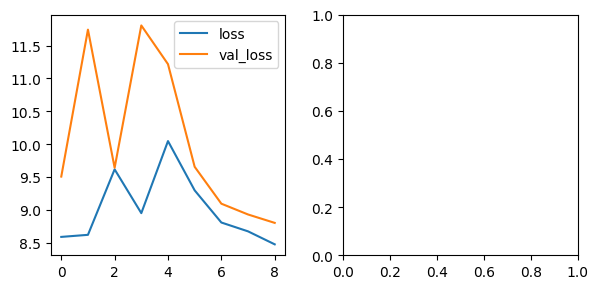

In [31]:
hist = model_ew.fit(train_ew, val_ds=val_ew, epochs=10, verbose=1, plot_hist=True, callbacks=[])


In [ ]:
train_ns, val_ns = ds_gen_ns.get_datasets(512, label_features=['NS_Node_Location'], shuffle=True, stride=1)

model_ns = prediction_models.Dense_NN(train_ns, conv1d_layers=[], dense_layers=[256, 128,64,32], l2_reg=0.0, mixed_dropout=0.0, lr_scheduler=[], seed=0)
train_ns = train_ns.map(lambda x,y:(x,y['NS_Node_Location']))
val_ns = val_ns.map(lambda x,y:(x,y['NS_Node_Location'])) # temporary fix to allow class weights

model_ns.summary()
hist = model_ns.fit(train_ns, val_ds=val_ns, epochs=20, verbose=1, plot_hist=False, class_weight={0: 0.5, 1: 20.0}, callbacks=[])
model_ns.model.save('models/ns_localizer.hdf5')

model_ns.plot_hist(hist, [k for k in hist.history.keys() if 'loss' in k])
model_ns.plot_hist(hist, [k for k in hist.history.keys() if 'accuracy' in k])

In [12]:
#model_ew = tf.keras.models.load_model('/home/david/Code/splid-challenge/wandb/run-20240115_185433-iebvf53e/files\model_iebvf53e.hdf5')
#model_ew.save('models/ew_localizer.hdf5')

model_ew = tf.keras.models.load_model('/home/david/Code/splid-challenge/wandb/run-20240112_140537-85ahbucq/files\model_85ahbucq.hdf5')
# 25 6 23

In [20]:
train_ew, val_ew = ds_gen_ew.get_datasets(512, label_features=['EW_Node_Location'], shuffle=False, stride=4)
model_ew.evaluate(val_ew)

51/51 [==============================] - 1s 10ms/step - loss: 0.0074 - binary_accuracy: 0.9986 - precision: 0.1429 - recall: 0.8571


[0.007437718100845814,
 0.9985650181770325,
 0.1428571492433548,
 0.8571428656578064]

In [61]:
evaluator, result_df = evaluation.evaluate_localizer(ds_gen_ew,
                                                            split_dataframes=split_dataframes,
                                                            gt_path=challenge_data_dir / 'train_labels.csv',
                                                            model=model_ew,
                                                            train=False,
                                                            with_initial_node=False,
                                                            remove_consecutives=True,
                                                            direction='EW',
                                                            prediction_threshold=0.5,
                                                            return_scores=False)

Cause: could not parse the source code of <function evaluate_localizer.<locals>.<lambda> at 0x7f3a739c7f40>: no matching AST found among candidates:
# coding=utf-8
lambda x, y, z: x
# coding=utf-8
lambda x, y, z: y
# coding=utf-8
lambda x, y, z: z
# coding=utf-8
lambda df: df.iloc[int(len(df) / 2), :]
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function evaluate_localizer.<locals>.<lambda> at 0x7f3a739c7f40>: no matching AST found among candidates:
# coding=utf-8
lambda x, y, z: x
# coding=utf-8
lambda x, y, z: y
# coding=utf-8
lambda x, y, z: z
# coding=utf-8
lambda df: df.iloc[int(len(df) / 2), :]
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function evaluate_localizer.<locals>.<lambda> at 0x7f3a739c7d00>: no matching AST found among candidates:
# coding=utf-8
lambda x, y, z: x
# coding=utf-8
lambda x,

['10', '104', '114', '115', '116', '119', '121', '123', '137', '139', '148', '15', '160', '161', '167', '171', '176', '184', '185', '193', '198', '199', '21', '211', '212', '221', '222', '227', '230', '233', '235', '238', '241', '245', '26', '30', '36', '45', '47', '50', '52', '60', '61', '66', '67', '73', '84', '87', '88', '91']


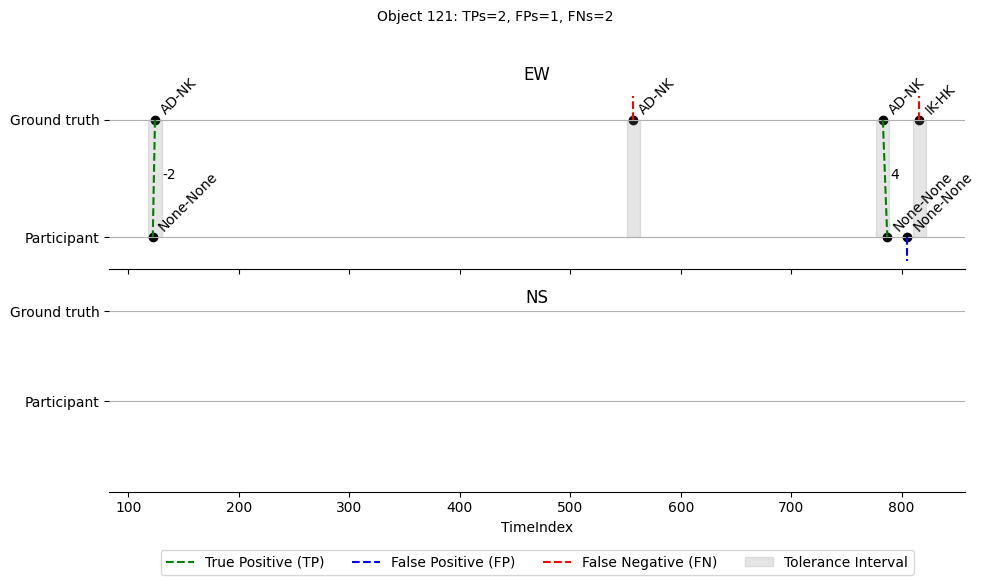

In [62]:
print(ds_gen_ew.val_keys)
evaluator.plot(121)

In [63]:
print(result_df.loc[(result_df['ObjectID'] == 123) & ((result_df['Location_Pred'] == True) | (result_df['Location'] == True))])

    ObjectID  TimeIndex  Location  Location_Pred Direction  Node  Type
19       123        122         0              1        EW  None  None


In [20]:

direction = 'EW'
ground_truth_from_file = pd.read_csv(labels_dir)
ground_truth_from_file = ground_truth_from_file[ground_truth_from_file['ObjectID'].isin([121,122,123])].copy()
ground_truth_from_file = ground_truth_from_file[(ground_truth_from_file['Direction'] == direction)]
ground_truth_from_file = ground_truth_from_file.sort_values(['ObjectID', 'TimeIndex']).reset_index(drop=True)

mergeDf = ground_truth_from_file.copy()
mergeDf = mergeDf.drop([4])
mergeDf.loc[-1] = [121, 817, 'EW', 'IK', 'HK']  # adding a row
mergeDf.index = mergeDf.index + 1  # shifting index
mergeDf = mergeDf.sort_index()  # sorting by index
print(mergeDf)
print(ground_truth_from_file)

evaluator = evaluation.NodeDetectionEvaluator(ground_truth_from_file, mergeDf)
precision, recall, f2, rmse, total_tp, total_fp, total_fn = evaluator.score()
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F2: {f2:.2f}')
print(f'RMSE: {rmse:.4}')
print(f'TP: {total_tp} FP: {total_fp} FN: {total_fn}')

    ObjectID  TimeIndex Direction Node Type
0        121        817        EW   IK   HK
1        121          0        EW   SS   NK
2        121        124        EW   AD   NK
3        121        557        EW   AD   NK
4        121        783        EW   AD   NK
6        122          0        EW   SS   NK
7        122        124        EW   AD   NK
8        122        557        EW   AD   NK
9        122        783        EW   AD   NK
10       122        816        EW   IK   HK
11       123          0        EW   SS   NK
12       123        124        EW   AD   NK
13       123        557        EW   AD   NK
14       123       1804        EW   AD   NK
    ObjectID  TimeIndex Direction Node Type
0        121          0        EW   SS   NK
1        121        124        EW   AD   NK
2        121        557        EW   AD   NK
3        121        783        EW   AD   NK
4        121        816        EW   IK   HK
5        122          0        EW   SS   NK
6        122        124        E

In [ ]:
eval_df = evaluation.localization_eval(ds_gen, challenge_data_dir / 'train_labels.csv', dense_model.model, train=True, add_initial_node=True)

2024-01-06 23:47:48.838844: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1028534400 exceeds 10% of free system memory.


In [10]:
false_preds = eval_df.loc[(eval_df['Location'] != eval_df['Location_Pred'])].sort_values(['ObjectID', 'TimeIndex']).reset_index(drop=True)
print(false_preds.head(80))
false_preds = eval_df[eval_df['Location'] != eval_df['Location_Pred']]
print(len(false_preds))
print(len(eval_df))

    ObjectID  TimeIndex  Location  Location_Pred Node Type Direction
0        106         69         0              1   AD   NK        EW
1        108        179         0              1   SS   NK        EW
2        114        201         0              1   AD   NK        EW
3        116        201         0              1   AD   NK        EW
4        117        461         0              1   AD   NK        EW
5        123        125         0              1   AD   NK        EW
6        124        367         0              1   AD   NK        EW
7        129        972         1              0   IK   CK        EW
8        130         86         1              0   IK   CK        EW
9        131        155         0              1   AD   NK        EW
10       135        936         1              0   IK   CK        EW
11       139       1009         1              0   AD   NK        EW
12       139       1098         1              0   IK   CK        EW
13       141        157         1 